In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')
sample1=pd.read_excel('Sample_Submission.xlsx')

In [3]:
train.head()

,Brand,Model_Info,Additional_Description,Locality,City,State,Price
0,1,name0 name234 64gb space grey,1yesr old mobile number 999two905two99 bill c...,878,8,2,15000
1,1,phone 7 name42 name453 new condition box acce...,101004800 1010065900 7000,1081,4,0,18800
2,1,name0 x 256gb leess used good condition,1010010000 seperate screen guard 3 back cover...,495,11,4,50000
3,1,name0 6s plus 64 gb space grey,without 1010020100 id 1010010300 colour 10100...,287,10,7,16500
4,1,phone 7 sealed pack brand new factory outet p...,101008700 10100000 xs max 64 gb made 10100850...,342,4,0,26499


In [4]:
test.head()

,Brand,Model_Info,Additional_Description,Locality,City,State
0,1,name0 55s66s66s778xxsxsmax etc,good condition 11months old single scratch we...,570,11,4
1,1,slightly used excellent condition name0 5 sale,101008700 1010030600 1010034300 10100192200 1...,762,8,2
2,1,name0 sx ios12 top letast model bill call,1010017300 delivery,60,13,5
3,1,name87 name0 x 64gb going lowest 41900,phone 1010023400 64 gb excellent condition sale,640,15,5
4,1,name0 5s proper condition one handedly used,full kit available 10100248300 condition 4gb ...,816,2,6


(array([  5.,   6.,  22.,  80., 167., 375., 800., 436., 321., 114.]),
 array([ 5.98896142,  6.56759271,  7.146224  ,  7.7248553 ,  8.30348659,
         8.88211788,  9.46074917, 10.03938047, 10.61801176, 11.19664305,
        11.77527434]),
 <a list of 10 Patch objects>)

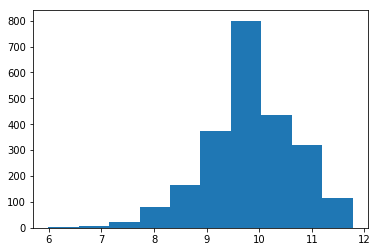

In [5]:
plt.hist(np.log(train['Price']))

In [6]:
train.shape , test.shape

((2326, 7), (997, 6))

In [7]:
train.describe()

,Brand,Locality,City,State,Price
count,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000
mean,1.047291,538.894239,7.294067,3.693465,25562.137145
std,0.396109,333.355186,5.408113,2.194072,21316.854497
min,0.000000,0.000000,0.000000,0.000000,399.000000
25%,1.000000,249.000000,2.000000,2.000000,12000.000000
50%,1.000000,534.000000,8.000000,4.000000,18945.000000
75%,1.000000,814.000000,11.000000,5.000000,30974.250000
max,3.000000,1191.000000,17.000000,8.000000,129998.000000


In [8]:
train['Model_Info'].value_counts()[:10]

 name0 7 32gb                                                      12
 name0 6 64gb                                                      12
 name0 7 128gb                                                     10
 name0 5s 16gb                                                      8
 name0 6s 64gb                                                      7
 name0 6 32gb                                                       6
 name0 x 256gb                                                      6
 name54 name0 7 128gbname54 sealedcodemiwarrantyexchenge option     6
 name0 6 name148                                                    6
 name0 6s 64 gb                                                     6
Name: Model_Info, dtype: int64

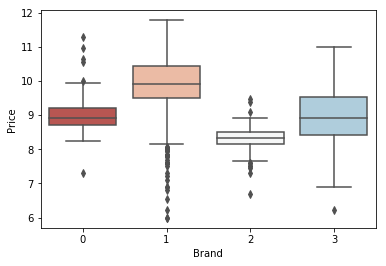

In [9]:
sns.boxplot(x = 'Brand', y = np.log(train['Price']+1), data = train, palette = sns.color_palette('RdBu',5))

In [45]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [46]:
y=np.log(train.Price)
train.drop('Price',axis=1,inplace=True)

In [47]:
merge: pd.DataFrame = pd.concat([train, test])

In [48]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

In [49]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_model = cv.fit_transform(merge['Model_Info'])
cv = CountVectorizer()
X_description = cv.fit_transform(merge['Additional_Description'])

In [50]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(3,3), stop_words='english')
X_desc = tv.fit_transform(merge['Additional_Description'])
X_mod=tv.fit_transform(merge['Model_Info'])

In [52]:
from scipy.sparse import csr_matrix, hstack

X_dummies = csr_matrix(pd.get_dummies(merge[['City', 'State','Brand','Locality']], sparse=True,drop_first=True).values)

In [60]:
sparse_merge = hstack((X_dummies, X_description, X_model, X_desc)).tocsr()

In [61]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [62]:
X = sparse_merge[:2326,:]
X_test = sparse_merge[2326:,:]

In [63]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_log_error
from math import sqrt
import lightgbm as lgb

In [64]:
x_train,x_cv,y_train,y_cv=train_test_split(X,y,test_size=0.20,random_state=1002)

In [22]:
train_X = lgb.Dataset(x_train, label=y_train)

params = {
        'learning_rate': 0.01,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'MSLE',
    }

In [23]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=5000, verbose_eval=100)

In [24]:
y_pred = gbm.predict(x_cv, num_iteration=gbm.best_iteration)

In [25]:
print('The rmsle of prediction is:', sqrt(mean_squared_log_error(y_cv, y_pred)))

The rmsle of prediction is: 0.0534444585764849


In [26]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gb=GradientBoostingRegressor(max_depth=7)
gb.fit(x_train,y_train)
gb_pred_cv=gb.predict(x_cv)
print(sqrt(mean_squared_log_error(y_cv,gb_pred_cv)))

0.05309431101432402


In [97]:
gb_pred=gb.predict(X_test)

In [65]:
import xgboost
from xgboost import XGBRegressor
xgb=XGBRegressor(max_depth=7,learning_rate=0.1)
xgb.fit(x_train,y_train)
xgb_cv=xgb.predict(x_cv)
print(sqrt(mean_squared_log_error(y_cv,xgb_cv)))

C:\Users\hp\Anaconda3\3.7\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.05233071169707832


In [66]:
xgb_pred=xgb.predict(X_test)

In [35]:
import catboost
from catboost import CatBoostRegressor
cb=CatBoostRegressor(max_depth=5)
cb.fit(x_train,y_train)
cb_cv=cb.predict(x_cv)           #0.05301469623602568
print(sqrt(mean_squared_log_error(y_cv,cb_cv)))

Learning rate set to 0.043589
0:	learn: 0.8191946	total: 225ms	remaining: 3m 44s
1:	learn: 0.8088075	total: 316ms	remaining: 2m 37s
2:	learn: 0.7992191	total: 400ms	remaining: 2m 12s
3:	learn: 0.7889610	total: 520ms	remaining: 2m 9s
4:	learn: 0.7774786	total: 615ms	remaining: 2m 2s
5:	learn: 0.7686425	total: 706ms	remaining: 1m 56s
6:	learn: 0.7587916	total: 874ms	remaining: 2m 3s
7:	learn: 0.7496738	total: 990ms	remaining: 2m 2s
8:	learn: 0.7408136	total: 1.08s	remaining: 1m 59s
9:	learn: 0.7338660	total: 1.15s	remaining: 1m 54s
10:	learn: 0.7274737	total: 1.25s	remaining: 1m 52s
11:	learn: 0.7218073	total: 1.37s	remaining: 1m 52s
12:	learn: 0.7158479	total: 1.44s	remaining: 1m 49s
13:	learn: 0.7101173	total: 1.58s	remaining: 1m 51s
14:	learn: 0.7052633	total: 1.66s	remaining: 1m 49s
15:	learn: 0.6990624	total: 1.76s	remaining: 1m 48s
16:	learn: 0.6943134	total: 1.87s	remaining: 1m 47s
17:	learn: 0.6901308	total: 2.01s	remaining: 1m 49s
18:	learn: 0.6850494	total: 2.09s	remaining: 1m 

157:	learn: 0.5227884	total: 19.4s	remaining: 1m 43s
158:	learn: 0.5226726	total: 19.5s	remaining: 1m 43s
159:	learn: 0.5217404	total: 19.6s	remaining: 1m 43s
160:	learn: 0.5210821	total: 19.7s	remaining: 1m 42s
161:	learn: 0.5208992	total: 19.8s	remaining: 1m 42s
162:	learn: 0.5207534	total: 19.9s	remaining: 1m 42s
163:	learn: 0.5205912	total: 20s	remaining: 1m 42s
164:	learn: 0.5200018	total: 20.2s	remaining: 1m 42s
165:	learn: 0.5198589	total: 20.3s	remaining: 1m 42s
166:	learn: 0.5197253	total: 20.4s	remaining: 1m 41s
167:	learn: 0.5190752	total: 20.5s	remaining: 1m 41s
168:	learn: 0.5186865	total: 20.6s	remaining: 1m 41s
169:	learn: 0.5182463	total: 20.7s	remaining: 1m 41s
170:	learn: 0.5180399	total: 20.8s	remaining: 1m 40s
171:	learn: 0.5178448	total: 20.8s	remaining: 1m 40s
172:	learn: 0.5176252	total: 20.9s	remaining: 1m 39s
173:	learn: 0.5170357	total: 21s	remaining: 1m 39s
174:	learn: 0.5168577	total: 21.1s	remaining: 1m 39s
175:	learn: 0.5164314	total: 21.2s	remaining: 1m 3

313:	learn: 0.4678589	total: 32.9s	remaining: 1m 11s
314:	learn: 0.4675343	total: 33s	remaining: 1m 11s
315:	learn: 0.4670923	total: 33.1s	remaining: 1m 11s
316:	learn: 0.4669737	total: 33.1s	remaining: 1m 11s
317:	learn: 0.4668469	total: 33.2s	remaining: 1m 11s
318:	learn: 0.4662501	total: 33.3s	remaining: 1m 11s
319:	learn: 0.4658822	total: 33.3s	remaining: 1m 10s
320:	learn: 0.4655626	total: 33.4s	remaining: 1m 10s
321:	learn: 0.4654435	total: 33.5s	remaining: 1m 10s
322:	learn: 0.4652775	total: 33.6s	remaining: 1m 10s
323:	learn: 0.4651617	total: 33.7s	remaining: 1m 10s
324:	learn: 0.4647444	total: 33.8s	remaining: 1m 10s
325:	learn: 0.4643949	total: 33.8s	remaining: 1m 9s
326:	learn: 0.4640472	total: 33.9s	remaining: 1m 9s
327:	learn: 0.4637225	total: 34s	remaining: 1m 9s
328:	learn: 0.4632728	total: 34.1s	remaining: 1m 9s
329:	learn: 0.4630710	total: 34.2s	remaining: 1m 9s
330:	learn: 0.4627826	total: 34.2s	remaining: 1m 9s
331:	learn: 0.4626600	total: 34.3s	remaining: 1m 9s
332:

473:	learn: 0.4318480	total: 46s	remaining: 51s
474:	learn: 0.4314348	total: 46.1s	remaining: 50.9s
475:	learn: 0.4313448	total: 46.1s	remaining: 50.8s
476:	learn: 0.4308996	total: 46.2s	remaining: 50.7s
477:	learn: 0.4307361	total: 46.3s	remaining: 50.6s
478:	learn: 0.4306476	total: 46.4s	remaining: 50.5s
479:	learn: 0.4305632	total: 46.5s	remaining: 50.4s
480:	learn: 0.4303464	total: 46.6s	remaining: 50.3s
481:	learn: 0.4301483	total: 46.7s	remaining: 50.2s
482:	learn: 0.4300206	total: 46.8s	remaining: 50.1s
483:	learn: 0.4298972	total: 46.9s	remaining: 50s
484:	learn: 0.4298092	total: 46.9s	remaining: 49.9s
485:	learn: 0.4295429	total: 47s	remaining: 49.7s
486:	learn: 0.4292830	total: 47.1s	remaining: 49.7s
487:	learn: 0.4291948	total: 47.2s	remaining: 49.6s
488:	learn: 0.4290032	total: 47.3s	remaining: 49.4s
489:	learn: 0.4289197	total: 47.4s	remaining: 49.3s
490:	learn: 0.4286622	total: 47.5s	remaining: 49.2s
491:	learn: 0.4285755	total: 47.5s	remaining: 49.1s
492:	learn: 0.428446

633:	learn: 0.4080619	total: 59.5s	remaining: 34.3s
634:	learn: 0.4079954	total: 59.6s	remaining: 34.2s
635:	learn: 0.4078603	total: 59.7s	remaining: 34.2s
636:	learn: 0.4077616	total: 59.8s	remaining: 34.1s
637:	learn: 0.4076543	total: 59.9s	remaining: 34s
638:	learn: 0.4074820	total: 1m	remaining: 33.9s
639:	learn: 0.4071015	total: 1m	remaining: 33.8s
640:	learn: 0.4067779	total: 1m	remaining: 33.7s
641:	learn: 0.4067254	total: 1m	remaining: 33.6s
642:	learn: 0.4066232	total: 1m	remaining: 33.6s
643:	learn: 0.4065611	total: 1m	remaining: 33.5s
644:	learn: 0.4063191	total: 1m	remaining: 33.4s
645:	learn: 0.4061937	total: 1m	remaining: 33.3s
646:	learn: 0.4059168	total: 1m	remaining: 33.2s
647:	learn: 0.4058527	total: 1m	remaining: 33.1s
648:	learn: 0.4057475	total: 1m 1s	remaining: 33s
649:	learn: 0.4056234	total: 1m 1s	remaining: 32.9s
650:	learn: 0.4054046	total: 1m 1s	remaining: 32.8s
651:	learn: 0.4051563	total: 1m 1s	remaining: 32.7s
652:	learn: 0.4049696	total: 1m 1s	remaining: 

791:	learn: 0.3879639	total: 1m 13s	remaining: 19.3s
792:	learn: 0.3877726	total: 1m 13s	remaining: 19.2s
793:	learn: 0.3877171	total: 1m 13s	remaining: 19.2s
794:	learn: 0.3875188	total: 1m 13s	remaining: 19.1s
795:	learn: 0.3873751	total: 1m 14s	remaining: 19s
796:	learn: 0.3872854	total: 1m 14s	remaining: 18.9s
797:	learn: 0.3872109	total: 1m 14s	remaining: 18.8s
798:	learn: 0.3871543	total: 1m 14s	remaining: 18.7s
799:	learn: 0.3870944	total: 1m 14s	remaining: 18.6s
800:	learn: 0.3870112	total: 1m 14s	remaining: 18.5s
801:	learn: 0.3869391	total: 1m 14s	remaining: 18.4s
802:	learn: 0.3868214	total: 1m 14s	remaining: 18.3s
803:	learn: 0.3867653	total: 1m 14s	remaining: 18.2s
804:	learn: 0.3867129	total: 1m 14s	remaining: 18.1s
805:	learn: 0.3866620	total: 1m 15s	remaining: 18.1s
806:	learn: 0.3866073	total: 1m 15s	remaining: 18s
807:	learn: 0.3865484	total: 1m 15s	remaining: 17.9s
808:	learn: 0.3864960	total: 1m 15s	remaining: 17.8s
809:	learn: 0.3864422	total: 1m 15s	remaining: 17.

949:	learn: 0.3708658	total: 1m 27s	remaining: 4.59s
950:	learn: 0.3708078	total: 1m 27s	remaining: 4.5s
951:	learn: 0.3706474	total: 1m 27s	remaining: 4.41s
952:	learn: 0.3705031	total: 1m 27s	remaining: 4.31s
953:	learn: 0.3704557	total: 1m 27s	remaining: 4.22s
954:	learn: 0.3702529	total: 1m 27s	remaining: 4.13s
955:	learn: 0.3702006	total: 1m 27s	remaining: 4.04s
956:	learn: 0.3700876	total: 1m 27s	remaining: 3.95s
957:	learn: 0.3700060	total: 1m 27s	remaining: 3.85s
958:	learn: 0.3698442	total: 1m 27s	remaining: 3.76s
959:	learn: 0.3697997	total: 1m 28s	remaining: 3.67s
960:	learn: 0.3697476	total: 1m 28s	remaining: 3.58s
961:	learn: 0.3695296	total: 1m 28s	remaining: 3.48s
962:	learn: 0.3694776	total: 1m 28s	remaining: 3.39s
963:	learn: 0.3694296	total: 1m 28s	remaining: 3.3s
964:	learn: 0.3693549	total: 1m 28s	remaining: 3.21s
965:	learn: 0.3692813	total: 1m 28s	remaining: 3.11s
966:	learn: 0.3691214	total: 1m 28s	remaining: 3.02s
967:	learn: 0.3690497	total: 1m 28s	remaining: 2

In [36]:
cb_pred=cb.predict(X_test)

In [67]:
sample=pd.DataFrame(np.exp(xgb_pred))

In [69]:
sample.columns=sample1.columns

In [70]:
sample.to_excel('xgb_pol.xlsx',index=False)

In [71]:
sample.head()

,Price
0,20592.732422
1,20434.738281
2,16834.906250
3,22888.484375
4,9210.860352
